# Pengenalan Etnis Indonesia Berdasarkan Citra Wajah Menggunakan *Gray Level Co-occurence Matrix* (GLCM) dan *Color Histogram*

Dinda Mareta Putriany <br> 1301164558

## *Import Library*

Import *library* yang digunakan

In [1]:
import os
import cv2
import xlsxwriter
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from shutil import copyfile
from skimage.measure import shannon_entropy
from kneed import KneeLocator
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## Mendefinisikan Function

###### Load Data

In [2]:
def load_data(data_dir):
    m = 0
    X, y, idx, name, fl = [], [], [], [], []
    labels = os.listdir(data_dir)
#     labels = ['Bugis', 'Melayu']
    for label in labels:
        datas_path = os.path.join(data_dir, label)
        datas = os.listdir(datas_path)
        fl.append(datas)
        for data in datas:
            data_path = os.path.join(datas_path, data)
            image_name = os.listdir(data_path)
#             image_name = shuffle(np.array(os.listdir(data_path)), random_state = 42)[:5]
            name.append(image_name)
            for img in image_name:
                img_path = os.path.join(data_path, img)
                image = cv2.imread(img_path)
                X.append(image)
                y.append(label)
                idx.append(m)
                m += 1
    return np.array(X), np.array(y), np.array(idx), name, fl

###### Preprocessing

In [3]:
# Mengubah citra RGB menjadi *grayscale* (GLCM)
def preprocessing_glcm(data):
    grays = []
    for i in range(len(data)):
        img = cv2.cvtColor(data[i], cv2.COLOR_BGR2GRAY)
        grays.append(img)
    return grays

In [4]:
# Mengubah citra RGB menjadi HSV (Color Histogram)
def preprocessing_color(array):
    preprocessed=[]
    for i in range(len(array)):
        img = array[i].copy()
        img=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        preprocessed.append(img)
    return preprocessed

###### Ekstraksi Ciri 

In [5]:
# Function feature extraction with GLCM
def glcm_extraction(data):
    feature = []
    for i in range (0, len(data)):
        distances = [1]     # Jarak dari satu tetangga ke tetangga lain
        angles = [0, np.pi/4, np.pi/2, 3/4*(np.pi)]   # Orientasi 0, 45, 90, dan 135
        # Proses glcm berupa correlation, symmetric, normalization
        # Correlation, dihitung jumlah kejadian satu level nilai intensitas piksel dengan intensitas piksel lain dalam jarak dan orientasi tertentu        
        # Symmetric, membuat matriks menjadi simetris pada bagian diagonalnya
        # Normalization, membagi setiap set pasangan piksel dengan total jumlah pasangan piksel
        glcm = greycomatrix(data[i], 
                            distances=distances, 
                            angles=angles, 
                            symmetric=True, 
                            normed=True, levels = 256)
        # Haralick Feature
        properties = ['contrast','homogeneity','correlation','ASM']
        feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
        
        # Entropy feature
        entropy = [shannon_entropy(glcm[:,:,:,idx]) for idx in range(glcm.shape[3])]
        feat = np.concatenate((entropy,feats),axis=0)
        feature.append(feat)
    return feature

In [6]:
# Function feature extraction with Color Histogram
def color_extraction(img):
    features = []           

    for i in range(np.shape(img)[0]):
        hist1 = cv2.calcHist([img[i]], [1], None, [16], [0, 256])
        hist2 = cv2.calcHist([img[i]], [2], None, [16], [0, 256])
        fitur = np.concatenate((hist1,hist2))
        arr = np.array(fitur).flatten()
        features.append(arr)
    return features

###### Cross Validation

In [7]:
# Fungsi Cross Validation menggunakan Random Forest
def crossVal(K,X,y):
    X,y = shuffle(X, y, random_state = 220)
    clf = RandomForestClassifier(n_estimators=200, random_state=0)
    cv = StratifiedKFold(n_splits=K) 
    scores = cross_val_score(clf, X, y,cv=cv)     
    return scores

In [8]:
# Fungsi Cross Validation menggunakan Random Forest
def CVSP(K,X,y):
    X,y = shuffle(X, y, random_state = 220)
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    cv = StratifiedKFold(n_splits=K) 
    scores = cross_val_score(clf, X, y,cv=cv)     
    return scores

In [9]:
# Fungsi Cross Validation menggunakan Random Forest
def SVM(K,X,y):
    scores = []
    X,y = shuffle(X, y, random_state = 220)
    clf = SVC(C=0.1, gamma= 1, kernel='poly')
    cv = StratifiedKFold(n_splits=K)   
    scores = cross_val_score(clf, X, y,cv=cv)     
    return scores

## Berdasarkan Periorbital Wajah

### Load Data

In [10]:
data, label, idx, img_name, fld = load_data('D:\Documents\Tugas_Akhir\Periorbital_Data')

In [11]:
print("Total Data Periorbital:", len(data))

Total Data Periorbital: 2290


In [12]:
periorbital = np.array(np.unique(label, return_counts=True)).T
print("Jumlah Data Setiap Kelas:")
periorbital

Jumlah Data Setiap Kelas:


array([['Banjar', '485'],
       ['Bugis', '465'],
       ['Jawa', '440'],
       ['Melayu', '455'],
       ['Sunda', '445']], dtype='<U21')

###### Sampel Data Periorbital

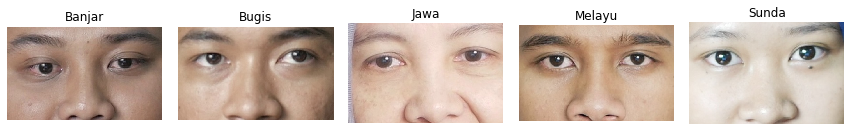

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(0,5):
    n = [11,595,1031,1482,2043]
    fidx = n[i]
    ax[i].imshow(cv2.cvtColor(data[fidx], cv2.COLOR_BGR2RGB))
    ax[i].set_title(label[i * 490 + (i+4) + 100])
    ax[i].axis('off')
plt.show()

###### Histogram Data Periorbital

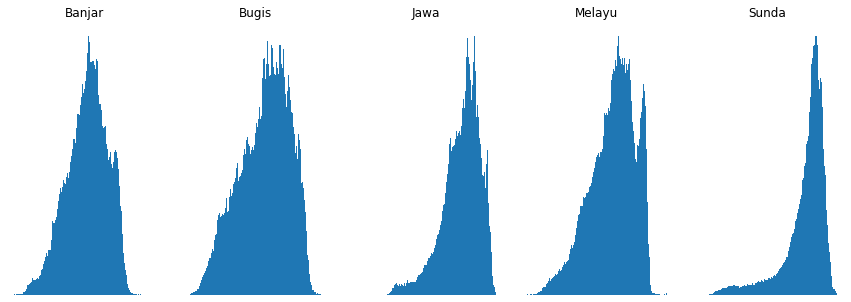

In [14]:
fig, ax1 = plt.subplots(1, 5, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(0,5):
    n = [11,595,1031,1482,2043]
    hidx = n[i]
    ax1[i].hist(data[hidx].ravel(), 256, [0,256])
    ax1[i].set_title(label[i * 490 + (i+4) + 100])
    ax1[i].axis('off')
plt.show()

#### Preprocessing

##### Preprocessing GLCM

In [15]:
glcm_prep = preprocessing_glcm(data)

Sampel Hasil Preprocessing: RGB to *Grayscale*

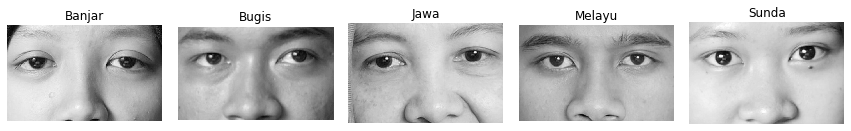

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(0,5):
    n = [9,595,1031,1482,2043]
    gidx = n[i]
    ax[i].imshow(glcm_prep[gidx], cmap=plt.cm.gray)
    ax[i].set_title(label[i * 490 + (i+4) + 100])
    ax[i].axis('off')
plt.show()

##### Preprocessing Color Histogram

In [17]:
color_prep = preprocessing_color(data)

Sampel Hasil Preprocessing: RGB to HSV

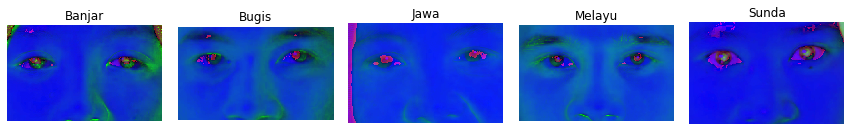

In [18]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(0,5):
    n = [9,595,1031,1482,2043]
    cidx = n[i]
    ax[i].imshow(color_prep[cidx], cmap=plt.cm.hsv)
    ax[i].set_title(label[i * 490 + (i+4) + 100])
    ax[i].axis('off')
plt.show()

### Feature Extraction

##### Ekstraksi ciri GLCM

In [19]:
glcm_feat = glcm_extraction(glcm_prep)

In [20]:
print("Panjang Fitur GLCM:", len(glcm_feat[0]))

Panjang Fitur GLCM: 20


##### Ekstraksi ciri Color Histogram

In [21]:
color_feat = color_extraction(color_prep)

In [22]:
print("Panjang Fitur Color Histogram:", len(color_feat[0]))

Panjang Fitur Color Histogram: 32


### Penggabungan Fitur Tekstur dan Warna

In [23]:
feature = np.concatenate((glcm_feat,color_feat),axis=1)

In [24]:
print("Panjang Fitur Gabungan:", len(feature[0]))

Panjang Fitur Gabungan: 52


### Pengujian

In [25]:
# Generate k
var = [int(x) for x in np.linspace(start = 2, stop = 20, num = 19)]
k = np.array(var)

##### Pengujian dengan Random Forest

In [86]:
# Pengujian dengan menggunakan k=2 sampai k=10
acc_rf = []
for i in range(len(k)):
    a1 = crossVal(k[i],feature,label)
    s1 = np.mean(a1)*100
    acc_rf.append(s1)
    print("Rata-rata akurasi", str(k[i]),": ",s1)
    i += 1

Rata-rata akurasi 2 :  91.04803493449782
Rata-rata akurasi 3 :  96.85589399792772
Rata-rata akurasi 4 :  97.33620437154468
Rata-rata akurasi 5 :  98.16593886462883
Rata-rata akurasi 6 :  98.64678237209877
Rata-rata akurasi 7 :  98.7336039808629
Rata-rata akurasi 8 :  98.34037913306206
Rata-rata akurasi 9 :  98.51508757483747
Rata-rata akurasi 10 :  98.60262008733625
Rata-rata akurasi 11 :  98.73314484558502
Rata-rata akurasi 12 :  98.7779002480022
Rata-rata akurasi 13 :  98.86462407648847
Rata-rata akurasi 14 :  98.68990615848313
Rata-rata akurasi 15 :  98.6466574934067
Rata-rata akurasi 16 :  98.82053710178711
Rata-rata akurasi 17 :  98.77735505479141
Rata-rata akurasi 18 :  98.95184000437445
Rata-rata akurasi 19 :  98.9078584891982
Rata-rata akurasi 20 :  98.86460717009916


Mencari k belokan (optimal) menggunakan knee locator

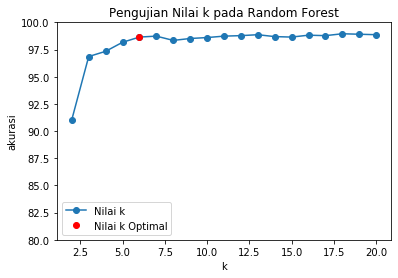

Nilai k Optimal:  6


In [87]:
xr = k
yr = acc_rf
# plotting the line 1 points  
plt.plot(k, acc_rf, marker='o', label="Nilai k")

# Plotting knee
KLr = KneeLocator(xr, yr, S=1.0, curve='concave', direction='increasing')
elr = KLr.knee-2
ykneer = acc_rf[elr]
xposr = yr.index(ykneer)
xkneer = xr[xposr]
plt.plot(xkneer, ykneer, "ro",label = "Nilai k Optimal")

# naming the x axis 
plt.xlabel('k') 
# naming the y axis 
plt.ylabel('akurasi') 
# giving a title to my graph 
plt.title('Pengujian Nilai k pada Random Forest') 
plt.legend()
plt.ylim([80, 100])

# function to show the plot 
plt.show() 

print("Nilai k Optimal: ",str(xkneer))

In [26]:
# Akurasi berdasarkan k optimal
rf = crossVal(6,feature,label)
print("Rata-rata akurasi : ",np.mean(rf)*100)

Rata-rata akurasi :  98.64678237209877


##### Pengujian dengan SVM

In [77]:
# Pengujian dengan menggunakan k=2 sampai k=10
acc_svm = []
for i in range(len(k)):
    a2 = SVM(k[i],feature,label)
    s2 = np.mean(a2)*100
    acc_svm.append(s2)
    print("Rata-rata akurasi", str(k[i]),": ",s2)
    i += 1

Rata-rata akurasi 2 :  83.23144104803494
Rata-rata akurasi 3 :  90.04389305556509
Rata-rata akurasi 4 :  90.91740502080816
Rata-rata akurasi 5 :  91.39737991266375
Rata-rata akurasi 6 :  91.83328523725112
Rata-rata akurasi 7 :  91.7467154684653
Rata-rata akurasi 8 :  91.70402767963743
Rata-rata akurasi 9 :  92.31640162626731
Rata-rata akurasi 10 :  92.05240174672488
Rata-rata akurasi 11 :  92.3580904741192
Rata-rata akurasi 12 :  92.14039680352714
Rata-rata akurasi 13 :  92.05236853541936
Rata-rata akurasi 14 :  92.66448985699321
Rata-rata akurasi 15 :  92.31481481481481
Rata-rata akurasi 16 :  92.13893745143746
Rata-rata akurasi 17 :  92.53471206061198
Rata-rata akurasi 18 :  92.7079915791776
Rata-rata akurasi 19 :  92.79578077424968
Rata-rata akurasi 20 :  92.75209763539284


Mencari k belokan (optimal) menggunakan knee locator

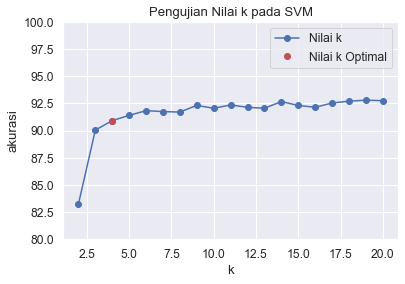

Nilai k Optimal:  4


In [78]:
xs = k
ys = acc_svm
# plotting the line 1 points  
plt.plot(xs, ys, marker='o', label="Nilai k")

# Plotting knee
KLs = KneeLocator(xs, ys, S=1.0, curve='concave', direction='increasing')
els = KLs.knee-2

yknees = acc_svm[els]
xposs = ys.index(yknees)
xknees = xs[xposs]
plt.plot(xknees, yknees, "ro",label = "Nilai k Optimal")

# naming the x axis 
plt.xlabel('k') 
# naming the y axis 
plt.ylabel('akurasi') 
# giving a title to my graph 
plt.title('Pengujian Nilai k pada SVM') 
plt.legend()
plt.ylim([80, 100])
# function to show the plot 
plt.show() 

print("Nilai k Optimal: ",str(xknees))

In [31]:
# Akurasi berdasarkan k optimal
svm = SVM(6,feature,label)
print("Rata-rata akurasi : ",np.mean(svm)*100)

Rata-rata akurasi :  91.74797194853261


### Hasil Pengujian

In [27]:
nid = []
fl = []
fol = []
fname = []
# memasukkan nama file data ke dalam array
for i in range(len(img_name)):
    for j in range(0,5):
        nm = img_name[i]
        nm2 = nm[j]
        nid.append(nm2)

# memasukkan nama folder ke dalam array
for i in range(len(fld)):
    fldb = fld[i]
    for j in range(len(fldb)):
        fo = fldb[j]
        fl.append(fo)
        
# menduplikat nama folder sebanyak 5x
for i in range(len(fl)):
    for j in range(0,5):
        bf = fl[i]
        fol.append(bf)

# menggabungkan nama folder dan nama file
for i in range(len(fol)):
    nms = str(fol[i]) + '_' + str(nid[i])
    fname.append(nms)

In [28]:
# Membuat confusion matrix setiap fold
xt, yt, tidx, pred = [], [], [], []
X, y, idx_data, imgn = shuffle(feature,label,idx, fname, random_state =220)
clf = RandomForestClassifier(n_estimators=200,random_state=0)
cv = StratifiedKFold(n_splits=6)
X = np.array(X)
y = np.array(y)
scoring = {'acc': 'accuracy',
           'prec_weighted': 'precision_weighted',
           'rec_weighted': 'recall_weighted',
           'f1_weighted': 'f1_weighted'}

###### Akurasi Tiap Fold dan Akurasi Terendah

In [29]:
print("Akurasi Tiap Fold:")
for i in range(len(rf)):
    acf = rf[i] 
    print("Fold ke-",i+1,':',acf*100)
print("Akurasi Terendah",min(rf)*100)

Akurasi Tiap Fold:
Fold ke- 1 : 98.95287958115183
Fold ke- 2 : 97.90575916230367
Fold ke- 3 : 98.69109947643979
Fold ke- 4 : 97.90575916230367
Fold ke- 5 : 99.21259842519686
Fold ke- 6 : 99.21259842519686
Akurasi Terendah 97.90575916230367


### Confusion Matrix

###### Confusion Matrix Setiap Fold

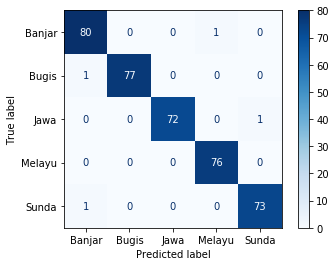

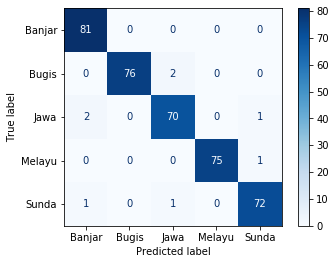

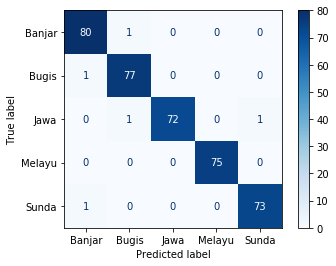

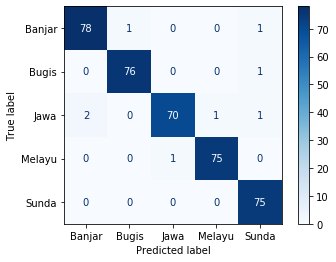

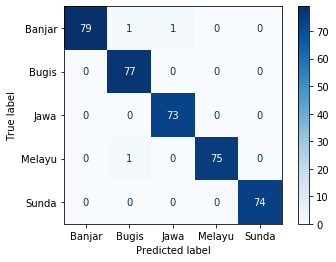

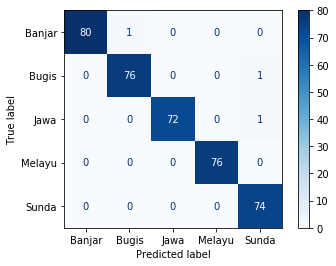

In [30]:
xtra, ytra,traid=[],[],[]
for train_index, test_index in cv.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    xtra.append(X_train)          # menyimpan X_test ke dalam array
    ytra.append(y_train)
    traid.append(train_index)
    xt.append(X_test)          # menyimpan X_test ke dalam array
    yt.append(y_test)          # menyimpan y_test ke dalam array
    tidx.append(test_index)    # menyimpan test_index ke dalam array
    pred.append(y_pred)        # menyimpan prediksi ke dalam array 
    plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues)
    plt.show()

###### Confusion Matrix dari Fold yang Memiliki Akurasi Terendah

Iterasi kedua

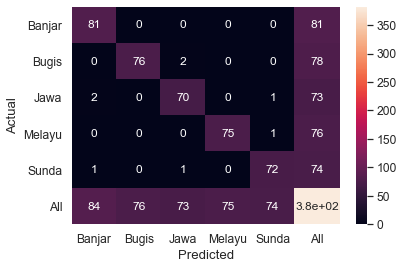

In [31]:
l_test = yt[1] 
l_pred = pred[1]
res_data = {'y_Actual': l_test, 'y_Predicted': l_pred}

df = pd.DataFrame(res_data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
sn.set(font_scale=1.1) # for label size
plt.figure(figsize=(6,4)) 
sn.heatmap(confusion_matrix, annot=True, annot_kws={"size": 12})
plt.show()

In [32]:
print("Jumlah Data Test:",len(l_test),'data')

Jumlah Data Test: 382 data


In [33]:
acc_min = np.array(np.unique(l_test, return_counts=True)).T
print("Jumlah Data Setiap Kelas:")
acc_min

Jumlah Data Setiap Kelas:


array([['Banjar', '81'],
       ['Bugis', '78'],
       ['Jawa', '73'],
       ['Melayu', '76'],
       ['Sunda', '74']], dtype='<U21')

Iterasi Keempat

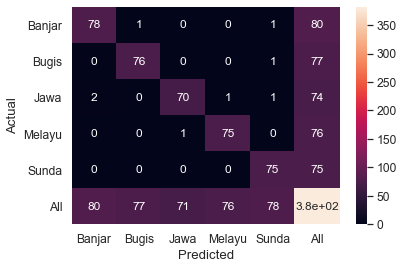

In [37]:
l_test2 = yt[3] 
l_pred2 = pred[3]
res_data = {'y_Actual': l_test2, 'y_Predicted': l_pred2}

df = pd.DataFrame(res_data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
sn.set(font_scale=1.1) # for label size
plt.figure(figsize=(6,4)) 
sn.heatmap(confusion_matrix, annot=True, annot_kws={"size": 12})
plt.show()

In [38]:
print("Jumlah Data Test:",len(l_test2),'data')

Jumlah Data Test: 382 data


In [39]:
acc_min = np.array(np.unique(l_test2, return_counts=True)).T
print("Jumlah Data Setiap Kelas:")
acc_min

Jumlah Data Setiap Kelas:


array([['Banjar', '80'],
       ['Bugis', '77'],
       ['Jawa', '74'],
       ['Melayu', '76'],
       ['Sunda', '75']], dtype='<U21')

### Classification Report

In [34]:
sc = cross_validate(clf, X, y, scoring=scoring,cv=cv)

###### Rata-Rata Akurasi, Precision, Recall, dan F1 Score

In [52]:
print("Rata-rata nilai akurasi:",np.mean(sc['test_acc']*100))
print("Rata-rata Precision Weighted:",np.mean(sc['test_prec_weighted']*100))
print("Rata-rata Recall Weighted:",np.mean(sc['test_rec_weighted']*100))
print("Rata-rata F1 Score Weighted:",np.mean(sc['test_f1_weighted']*100))

Rata-rata nilai akurasi: 98.64678237209877
Rata-rata Precision Weighted: 98.6635556014046
Rata-rata Recall Weighted: 98.64678237209877
Rata-rata F1 Score Weighted: 98.64707579907933


###### Classification Report Setiap Fold

In [68]:
report = []
for i in range(0,6):
    cr = classification_report(yt[i], pred[i])
    report.append(cr)

In [69]:
print(report[1])

              precision    recall  f1-score   support

      Banjar       0.96      1.00      0.98        81
       Bugis       1.00      0.97      0.99        78
        Jawa       0.96      0.96      0.96        73
      Melayu       1.00      0.99      0.99        76
       Sunda       0.97      0.97      0.97        74

    accuracy                           0.98       382
   macro avg       0.98      0.98      0.98       382
weighted avg       0.98      0.98      0.98       382



###### Calssification Report Fold Dengan Akurasi Rendah

In [64]:
# Iterasi kedua
print(classification_report(l_test, l_pred))

              precision    recall  f1-score   support

      Banjar       0.96      1.00      0.98        81
       Bugis       1.00      0.97      0.99        78
        Jawa       0.96      0.96      0.96        73
      Melayu       1.00      0.99      0.99        76
       Sunda       0.97      0.97      0.97        74

    accuracy                           0.98       382
   macro avg       0.98      0.98      0.98       382
weighted avg       0.98      0.98      0.98       382



In [40]:
# Iterasi keempat
print(classification_report(l_test2, l_pred2))

              precision    recall  f1-score   support

      Banjar       0.97      0.97      0.97        80
       Bugis       0.99      0.99      0.99        77
        Jawa       0.99      0.95      0.97        74
      Melayu       0.99      0.99      0.99        76
       Sunda       0.96      1.00      0.98        75

    accuracy                           0.98       382
   macro avg       0.98      0.98      0.98       382
weighted avg       0.98      0.98      0.98       382



### Data Yang Salah Terprediksi

###### Iterasi kedua

In [41]:
S_pred = np.asarray(np.where(l_test != l_pred)) #Mencari data yang salah terprediksi

In [42]:
tst_idx = tidx[1]                # test index fold dengan akurasi terendah  
for i in range(len(S_pred)):
    idv = S_pred[i]      # get index salah prediksi
    act = l_test[idv]    # get label aktual dari index salah prediksi
    prd = l_pred[idv]    # get label prediksi dari index salah prediksi      
    dt_idx = tst_idx[idv]        # get index data test from test_index
    data_act = idx_data[dt_idx]     # get index data actual form idx_data

In [43]:
print("Jumlah Data Salah Prediksi:",len(idv),"data")

Jumlah Data Salah Prediksi: 8 data


###### Iterasi Keempat

In [44]:
S_pred2 = np.asarray(np.where(l_test2 != l_pred2)) #Mencari data yang salah terprediksi

In [55]:
tst_idx2 = tidx[3]                # test index fold dengan akurasi terendah  
for i in range(len(S_pred2)):
    idv2 = S_pred2[i]      # get index salah prediksi
    act2 = l_test2[idv2]    # get label aktual dari index salah prediksi
    prd2 = l_pred2[idv2]    # get label prediksi dari index salah prediksi      
    dt_idx2 = tst_idx2[idv2]        # get index data test from test_index
    data_act2 = idx_data[dt_idx2]     # get index data actual form idx_data

In [56]:
print("Jumlah Data Salah Prediksi:",len(idv2),"data")

Jumlah Data Salah Prediksi: 8 data


###### Index Data Sesungguhnya (Dataset) Yang Salah Terprediksi

In [57]:
# Iterasi kedua
print("Index data salah prediksi:",data_act)

Index data salah prediksi: [1162 1525  733 1965 1380  941 1972 1383]


In [58]:
# Iterasi keempat
print("Index data salah prediksi:",data_act2)

Index data salah prediksi: [1613  643 1323 1092   90 1320   38 1262]


###### Tabel Label Data Yang Salah Terprediksi

In [59]:
fig = go.Figure(data=[go.Table(header=dict(values=['<b>Wrong Predict Index</b>','<b>Actual Class</b>','<b>Predicted Class</b>'
    ,'<b>Test Index (After Random)</b>','<b>Index Data</b>'],
    line_color='darkslategray',fill_color='grey',align='center',font=dict(color='white', size=12)),
  cells=dict(values=[idv,act,prd,dt_idx,data_act],line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [['white']*5],align = ['center'],font = dict(color = 'darkslategray', size = 12)))])
fig.update_layout(width=800, height=600)
fig.show()

In [60]:
fig = go.Figure(data=[go.Table(header=dict(values=['<b>Wrong Predict Index</b>','<b>Actual Class</b>','<b>Predicted Class</b>'
    ,'<b>Test Index (After Random)</b>','<b>Index Data</b>'],
    line_color='darkslategray',fill_color='grey',align='center',font=dict(color='white', size=12)),
  cells=dict(values=[idv2,act2,prd2,dt_idx2,data_act2],line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [['white']*5],align = ['center'],font = dict(color = 'darkslategray', size = 12)))])
fig.update_layout(width=800, height=600)
fig.show()

In [61]:
# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('featuri.xlsx')
worksheet = workbook.add_worksheet()
# Add a bold format to use to highlight cells.
bold = workbook.add_format({'bold': True})
# Some data we want to write to the worksheet.
expenses = []
# sh = ['B1','C1','D1','E1','F1','G1','H1','I1']
# hn = ['Data 1','Data 2','Data 3','Data 4','Data 5','Data 6','Data 7','Data 8']
a=0
for i in range(len(feature)):
    f = feature[i]
    for j in range(len(f)):
        # Write some data headers.
#         worksheet.write(sh[i],hn[i], bold)
        # Start from the first cell below the headers.
        row = 1+a
        col = 1
#         exp = f[j]
        # Iterate over the data and write it out row by row.
        for item in (f):
            worksheet.write(row, col,  item)
            col += 1
        a+=1
workbook.close()

###### Citra Yang Salah Terprediksi

###### Iterasi kedua

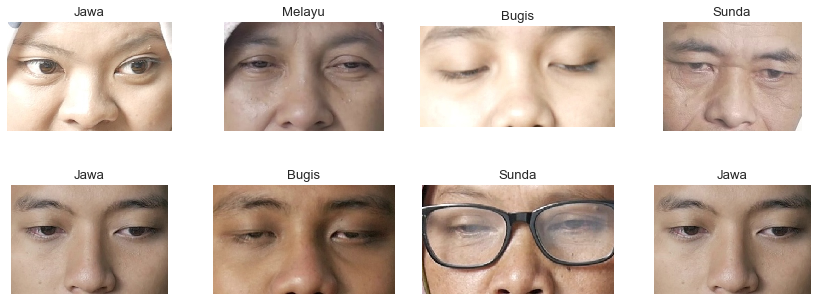

In [105]:
fig, ax = plt.subplots(2, 4, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
b = 0
for i in range(0,2):
    for j in range(0,4):
        ds1 = data_act
        t1 = ds1[b]
        ax[i,j].imshow(cv2.cvtColor(data[t1], cv2.COLOR_BGR2RGB))
        ax[i,j].set_title(label[t1])
        ax[i,j].axis('off')
        b += 1
plt.show()

In [128]:
# save image
nam = []
for i in range (len(data_act)):
    ct = data_act[i]
    fn = str(label[ct]) + '_' + str(fname[ct])
    filename = "D:\Documents\Tugas_Akhir\Hasil_Prediksi(Salah)/" + fn
    cv2.imwrite(filename,data[ct])
    nam.append(fn)

###### Iterasi keempat

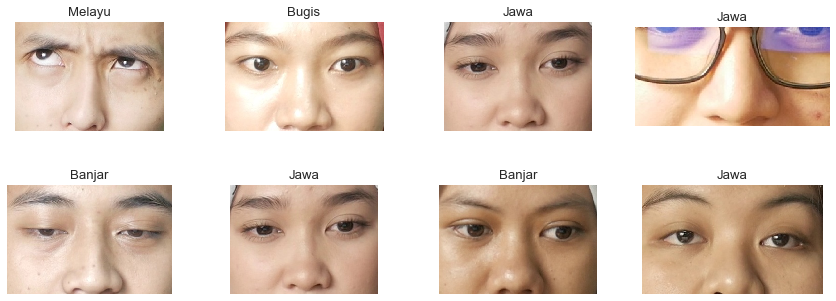

In [62]:
fig, ax = plt.subplots(2, 4, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
b = 0
for i in range(0,2):
    for j in range(0,4):
        ds1 = data_act2
        t1 = ds1[b]
        ax[i,j].imshow(cv2.cvtColor(data[t1], cv2.COLOR_BGR2RGB))
        ax[i,j].set_title(label[t1])
        ax[i,j].axis('off')
        b += 1
plt.show()

In [ ]:
# save image
for i in range (len(data_act)):
    ct2 = data_act[i]
    filename = "D:\Documents\Tugas_Akhir/" + str(label[ct2]) + '_' + str(fname[ct2])
    cv2.imwrite(filename,data[ct2])

###### Fitur GLCM Yang Salah Terprediksi

In [426]:
# Memasukkan fitur glcm yang salah terprediksi ke dalam array pada iterasi kedua
gfeat_act = []
for i in range(len(data_act)):
    ft = data_act[i]
    ft2 = glcm_feat[ft]
    gfeat_act.append(ft2)

In [59]:
# Memasukkan fitur glcm yang salah terprediksi ke dalam array pada iterasi keempat
gfeat_act2 = []
for i in range(len(data_act2)):
    ftr = data_act2[i]
    ftr2 = glcm_feat[ftr]
    gfeat_act2.append(ftr2)

In [65]:
data_act

array([1162, 1525,  733, 1965, 1380,  941, 1972, 1383])

In [ ]:
ba = 0,485
bu = 485,950
ja = 950,1390
me = 1390,1845
su = 1845,2290

In [442]:
# Menghitung euclidean distance
euc = []
eid = []
for i in range(1845,2290):
    p1 = glcm_feat[i]
    p2 = gfeat_act[0]
    d = distance.euclidean(p1, p2)
    euc.append(d)
    eid.append(i)

In [440]:
for i in range(len(euc)):
    bn = euc[i]
    print(i,bn)

0 62.41950682727185
1 38.111884222680466
2 57.6422055519198
3 62.44058431759657
4 60.94278976461498
5 80.80866943179817
6 85.72148721659875
7 80.8382285799826
8 76.80197532074047
9 86.4696631199994
10 51.608467781276
11 58.95840953688888
12 59.07011242144002
13 51.69896269279149
14 53.165023372082274
15 327.30901288662767
16 307.06266285988875
17 327.2010916011513
18 327.2010916011513
19 302.53970413418483
20 62.21125961034921
21 67.73349101183452
22 62.21048862381243
23 62.233846523853316
24 60.94646422778549
25 62.58258880891149
26 72.12306436843213
27 62.610796223586064
28 69.28557620909288
29 72.56151838883461
30 14.979317787398914
31 28.19259298122915
32 12.487613100907577
33 15.0096664913149
34 17.193891680632085
35 78.73144786446116
36 74.59755537223127
37 75.348088820527
38 78.74722872648998
39 75.98219005355665
40 23.705037759768405
41 21.297693680416817
42 21.967524159446008
43 23.73489168078223
44 21.094465735247898
45 575.8785315868073
46 589.0956550043558
47 575.8645377464

In [444]:
eid[193]

2038

In [281]:
# Rata-rata euclidean distance
mean = np.mean(euc)
print(mean)

75.09931260050448


In [282]:
# Menghitung jumlah jarak dibawah rata2 pada kelas
n = shuffle(euc, random_state=220)
jum = 0
for i in range(0,400):
    if(n[i] < mean):
        jum += 1

In [283]:
jum

285

Simpan fitur ke excel

In [ ]:
# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('Fitur_GLCM_Salah_Prediksi.xlsx')
worksheet = workbook.add_worksheet()
# Add a bold format to use to highlight cells.
bold = workbook.add_format({'bold': True})
# Some data we want to write to the worksheet.
expenses = gfeat_act
sh = ['B1','C1','D1','E1','F1','G1','H1','I1']
hn = ['Data 1','Data 2','Data 3','Data 4','Data 5','Data 6','Data 7','Data 8']
a=0
for i in range(0,8):
    # Write some data headers.
    worksheet.write(sh[i],hn[i], bold)
    # Start from the first cell below the headers.
    row = 1
    col = 1+a
    exp = expenses[a]
    # Iterate over the data and write it out row by row.
    for item in (exp):
        worksheet.write(row, col,  item)
        row += 1
    a+=1
workbook.close()

###### Fitur Color Histogram Yang Salah Terprediksi

In [77]:
# Iterasi kedua
cfeat_act = []
for i in range(len(data_act)):
    fc = data_act[i]
    fc2 = color_prep[fc]
    cfeat_act.append(fc2)

In [78]:
# Iterasi keempat
cfeat_act2 = []
for i in range(len(data_act2)):
    fcr = data_act2[i]
    fcr2 = color_prep[fcr]
    cfeat_act2.append(fcr2)

In [57]:
ba = 0,485
bu = 485,950
ja = 950,1390
me = 1390,1845
su = 1845,2290

In [358]:
# Menghitung euclidean distance
euc = []
eid = []
for j in range(1845,2290):
    p1 = color_feat[j]
    p2 = cfeat_act[6]
    d = distance.euclidean(p1, p2)
    euc.append(d)
    eid.append(i)

In [359]:
# Rata-rata euclidean distance
mean = np.mean(euc)
print(mean)

33587.587551571276


In [360]:
# Menghitung jumlah jarak dibawah rata2 pada kelas
# n = shuffle(euc, random_state=220)
jum = 0
for i in range(0,400):
    if(euc[i] < mean):
        jum += 1

In [86]:
# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('CH_Salah_Prediksi.xlsx')
worksheet = workbook.add_worksheet()
# Add a bold format to use to highlight cells.
bold = workbook.add_format({'bold': True})
# Some data we want to write to the worksheet.
expenses = cfeat_act2
sh = ['B1','C1','D1','E1','F1','G1','H1','I1']
hn = ['Data 1','Data 2','Data 3','Data 4','Data 5','Data 6','Data 7','Data 8']
a=0
for i in range(len(expenses)):
    for j in range(len(cfeat_act[0])):
        # Write some data headers.
        worksheet.write(sh[i],hn[i], bold)
        # Start from the first cell below the headers.
        row = 1
        col = 1+a
        exp = expenses[a]
        # Iterate over the data and write it out row by row.
        for item in (exp):
            worksheet.write(row, col,  item)
            row += 1
    a+=1
workbook.close()

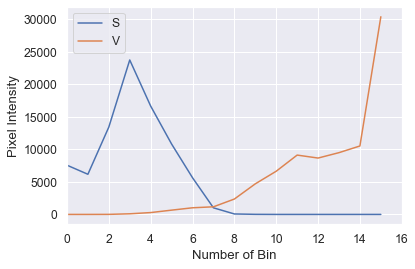

In [79]:
# Histogram dari channel S dan V iterasi kedua
hist1 = cv2.calcHist([cfeat_act[0]],[1],None,[16],[0,256])
hist2 = cv2.calcHist([cfeat_act[0]],[2],None,[16],[0,256])
plt.plot(hist1, label="S")
plt.plot(hist2, label="V")
plt.xlim([0,16])
plt.legend()
plt.xlabel("Number of Bin")
plt.ylabel("Pixel Intensity")
plt.show()

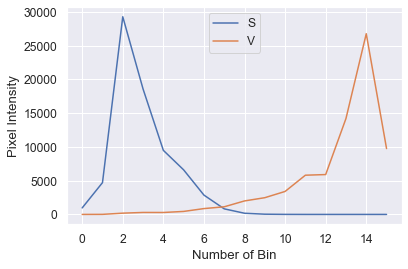

In [80]:
# Histogram dari channel S dan V iterasi keempat
histr1 = cv2.calcHist([cfeat_act2[0]],[1],None,[16],[0,256])
histr2 = cv2.calcHist([cfeat_act2[0]],[2],None,[16],[0,256])
plt.plot(histr1, label="S")
plt.plot(histr2, label="V")
# plt.xlim([0,16])
plt.legend()
plt.xlabel("Number of Bin")
plt.ylabel("Pixel Intensity")
plt.show()

### Feature Importance Random Forest

Feature: 0, Score: 0.01494
Feature: 1, Score: 0.01662
Feature: 2, Score: 0.01709
Feature: 3, Score: 0.01570
Feature: 4, Score: 0.01606
Feature: 5, Score: 0.01540
Feature: 6, Score: 0.01477
Feature: 7, Score: 0.01528
Feature: 8, Score: 0.01311
Feature: 9, Score: 0.01303
Feature: 10, Score: 0.01224
Feature: 11, Score: 0.01313
Feature: 12, Score: 0.01951
Feature: 13, Score: 0.01840
Feature: 14, Score: 0.01826
Feature: 15, Score: 0.01804
Feature: 16, Score: 0.01654
Feature: 17, Score: 0.01698
Feature: 18, Score: 0.01670
Feature: 19, Score: 0.01777
Feature: 20, Score: 0.01952
Feature: 21, Score: 0.02176
Feature: 22, Score: 0.02222
Feature: 23, Score: 0.02427
Feature: 24, Score: 0.02457
Feature: 25, Score: 0.02932
Feature: 26, Score: 0.02530
Feature: 27, Score: 0.02789
Feature: 28, Score: 0.02707
Feature: 29, Score: 0.02362
Feature: 30, Score: 0.01639
Feature: 31, Score: 0.01447
Feature: 32, Score: 0.00960
Feature: 33, Score: 0.00913
Feature: 34, Score: 0.00782
Feature: 35, Score: 0.01093
Fe

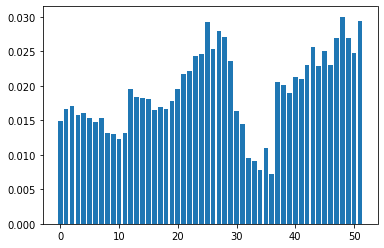

In [43]:
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
X,y=shuffle(feature,label,random_state=220)

# define the model
model = RandomForestClassifier(n_estimators = 200, random_state=0)
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Fitur Holistik Wajah

### Load Data

In [53]:
data_wajah, label_wajah, _, _, _ = load_data('D:\Documents\Tugas_akhir\Wajah')

In [54]:
print("Total data:",len(data_wajah))

Total data: 2500


In [55]:
wajah = np.array(np.unique(label_wajah, return_counts=True)).T
print("Jumlah Data Setiap Kelas:")
wajah

Jumlah Data Setiap Kelas:


array([['Banjar', '500'],
       ['Bugis', '500'],
       ['Jawa', '500'],
       ['Melayu', '500'],
       ['Sunda', '500']], dtype='<U21')

Sampel Data Holistik Wajah

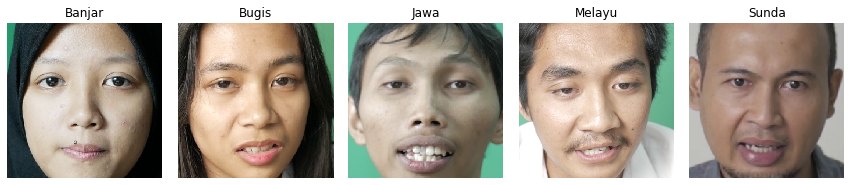

In [56]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(0,5):
    n = [9,595,1031,1482,2043]
    idx = n[i]
    ax[i].imshow(cv2.cvtColor(data_wajah[idx], cv2.COLOR_BGR2RGB))
    ax[i].set_title(label_wajah[i * 490 + (i+4) + 100])
    ax[i].axis('off')
plt.show()

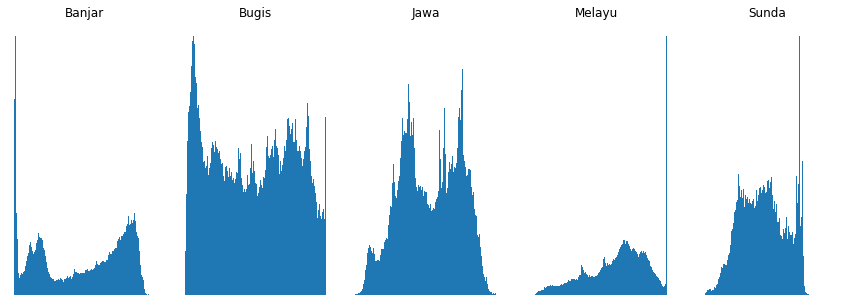

In [57]:
fig, ax1 = plt.subplots(1, 5, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(0,5):
    n = [9,595,1031,1482,2043]
    idx = n[i]
    ax1[i].hist(data_wajah[idx].ravel(), 256, [0,256])
    ax1[i].set_title(label_wajah[i * 490 + (i+4) + 100])
    ax1[i].axis('off')
plt.show()

### Preprocessing

###### Preprocessing GLCM

In [58]:
glcm_pw = preprocessing_glcm(data_wajah)

Sampel Hasil Preprocessing: RGB to *Grayscale*

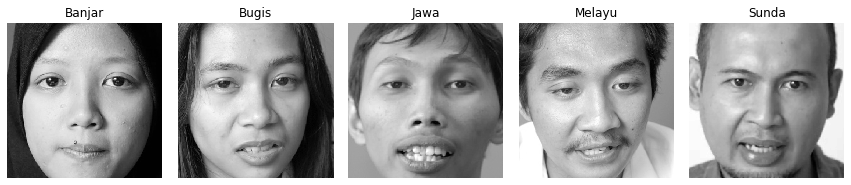

In [59]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(0,5):
    n = [9,595,1031,1482,2043]
    idx = n[i]
    ax[i].imshow(glcm_pw[idx], cmap=plt.cm.gray)
    ax[i].set_title(label_wajah[i * 490 + (i+4) + 100])
    ax[i].axis('off')
plt.show()

###### Preprocessing Color Histogram

In [60]:
color_pw = preprocessing_color(data_wajah)

Sampel Hasil Preprocessing: RGB to HSV

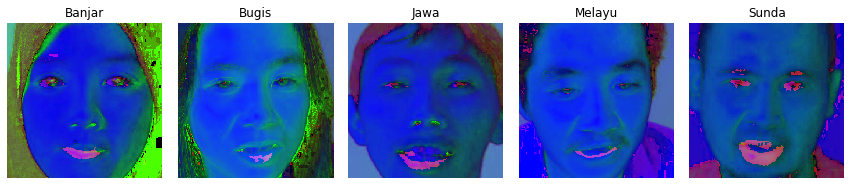

In [61]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(0,5):
    n = [9,595,1031,1482,2043]
    idx = n[i]
    ax[i].imshow(color_pw[idx], cmap=plt.cm.hsv)
    ax[i].set_title(label_wajah[i * 490 + (i+4) + 100])
    ax[i].axis('off')
plt.show()

### Ekstraksi Ciri

###### Ekstraksi Fitur GLCM

In [62]:
glcm_fw = glcm_extraction(glcm_pw)

In [63]:
print("Panjang Fitur GLCM:", len(glcm_fw[0]))

Panjang Fitur GLCM: 20


###### Ekstraksi Fitur *Color Histogram*

In [64]:
color_fw = color_extraction(color_pw)

In [65]:
print("Panjang Fitur Color Histogram:", len(color_fw[0]))

Panjang Fitur Color Histogram: 32


### Penggabungan Fitur Tekstur GLCM dan Warna

In [66]:
feat_wajah = np.concatenate((glcm_fw,color_fw),axis=1)

In [67]:
print("Panjang Fitur Gabungan:", len(feat_wajah[0]))

Panjang Fitur Gabungan: 52


### Pengujian

In [68]:
# Pengujian dengan menggunakan k=2 sampai k=10
acc_rfw = []
for i in range(len(k)):
    a3 = CVSP(k[i],feat_wajah,label_wajah)
    s3 = np.mean(a3)*100
    acc_rfw.append(s3)
    print("Rata-rata akurasi", str(k[i]),": ",s3)
    i += 1

Rata-rata akurasi 2 :  87.48
Rata-rata akurasi 3 :  93.32020578015378
Rata-rata akurasi 4 :  94.52000000000001
Rata-rata akurasi 5 :  95.24
Rata-rata akurasi 6 :  95.5205066715858
Rata-rata akurasi 7 :  95.88025154195758
Rata-rata akurasi 8 :  95.75960514458916
Rata-rata akurasi 9 :  96.35973531643998
Rata-rata akurasi 10 :  96.12
Rata-rata akurasi 11 :  96.0807354790661
Rata-rata akurasi 12 :  96.8408784198258
Rata-rata akurasi 13 :  96.68152982595987
Rata-rata akurasi 14 :  96.35952366006977
Rata-rata akurasi 15 :  96.71885145371905
Rata-rata akurasi 16 :  96.76067695574065
Rata-rata akurasi 17 :  96.95986502709192
Rata-rata akurasi 18 :  96.79850322640439
Rata-rata akurasi 19 :  96.92099784506372
Rata-rata akurasi 20 :  96.44


Mencari k belokan (optimal) menggunakan knee locator

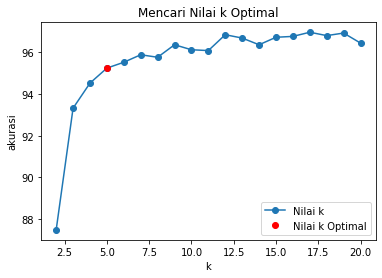

Nilai k Optimal:  5


In [69]:
xw = k
yw = acc_rfw
# plotting the line 1 points  
plt.plot(xw, yw, marker='o', label="Nilai k")

# Plotting knee
KLw = KneeLocator(xw, yw, S=1.0, curve='concave', direction='increasing')
elw = KLw.knee-2

ykneew = acc_rfw[elw]
xposw = yw.index(ykneew)
xkneew = xw[xposw]
plt.plot(xkneew, ykneew, "ro",label = "Nilai k Optimal")

# naming the x axis 
plt.xlabel('k') 
# naming the y axis 
plt.ylabel('akurasi') 
# giving a title to my graph 
plt.title('Mencari Nilai k Optimal') 
plt.legend()

# function to show the plot 
plt.show() 

print("Nilai k Optimal: ",str(xkneew))

In [518]:
rfw = CVSP(4,feat_wajah,label_wajah)
print("Rata-rata akurasi : ",np.mean(rfw)*100)

Rata-rata akurasi :  96.0


In [361]:
# Membuat confusion matrix setiap fold
xt, yt, tidx, pred = [], [], [], []
X, y = shuffle(feat_wajah,label_wajah, random_state =220)
clf = RandomForestClassifier(n_estimators=200,random_state=0)
cv = StratifiedKFold(n_splits=6)
X = np.array(X)
y = np.array(y)
scoring = {'acc': 'accuracy',
           'prec_weighted': 'precision_weighted',
           'rec_weighted': 'recall_weighted',
           'f1_weighted': 'f1_weighted'}

In [362]:
sc2 = cross_validate(clf, X, y, scoring=scoring,cv=cv)

In [363]:
print("Rata-rata nilai akurasi:",np.mean(sc2['test_acc']*100))
print("Rata-rata Precision Weighted:",np.mean(sc2['test_prec_weighted']*100))
print("Rata-rata Recall Weighted:",np.mean(sc2['test_rec_weighted']*100))
print("Rata-rata F1 Score Weighted:",np.mean(sc2['test_f1_weighted']*100))

Rata-rata nilai akurasi: 96.16018723482752
Rata-rata Precision Weighted: 96.25786221072549
Rata-rata Recall Weighted: 96.16018723482752
Rata-rata F1 Score Weighted: 96.16246727657877


In [359]:
print("Rata-rata nilai akurasi:",np.mean(sc['test_acc']*100))
print("Rata-rata Precision Weighted:",np.mean(sc['test_prec_weighted']*100))
print("Rata-rata Recall Weighted:",np.mean(sc['test_rec_weighted']*100))
print("Rata-rata F1 Score Weighted:",np.mean(sc['test_f1_weighted']*100))

Rata-rata nilai akurasi: 98.64678237209877
Rata-rata Precision Weighted: 98.6635556014046
Rata-rata Recall Weighted: 98.64678237209877
Rata-rata F1 Score Weighted: 98.64707579907933


### Tuning

#### Hyperparameter Random Forest

Set n_estimators atau jumlah pohon 

In [220]:
n_estimator = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

In [275]:
random_grid = {'n_estimators': n}
# Create a based model
rf = RandomForestClassifier()

###### Random Search CV

In [340]:
# Instantiate the grid search model
rf_randoms = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 6, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_randoms.fit(feature, label)

C:\Users\Dinda Mareta\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished


RandomizedSearchCV(cv=6, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [529]:
print("Jumlah Pohon Optimal:") # print best parameter after tuning 
print(rf_randoms.best_params_)
print("Parameter Lain yang Digunakan:") # Print how our model looks after hyper-parameter tuning 
print(rf_randoms.best_estimator_)

Jumlah Pohon Optimal:
{'n_estimators': 180}
Parameter Lain yang Digunakan:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


###### Grid Search CV

In [330]:
# Instantiate the grid search model
grid_searchRF = GridSearchCV(estimator = rf, param_grid = random_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_searchRF.fit(feature, label)

Fitting 6 folds for each of 20 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   32.8s finished


GridSearchCV(cv=6, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [528]:
print("Jumlah Pohon Optimal:") # print best parameter after tuning 
print(grid_searchRF.best_params_)
print("Parameter Lain yang Digunakan:") # Print how our model looks after hyper-parameter tuning 
print(grid_searchRF.best_estimator_)

Jumlah Pohon Optimal:
{'n_estimators': 200}
Parameter Lain yang Digunakan:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


###### Perbandingan Akurasi

In [389]:
# Fungsi Cross Validation menggunakan Random Forest
def HRF(K,X,y):
    X,y = shuffle(X, y, random_state = 220)
    clf = RandomForestClassifier(n_estimators=200, random_state=0)
    cv = StratifiedKFold(n_splits=K) 
    scores = cross_val_score(clf, X, y, cv=cv)     
    return scores

###### Random Search

In [382]:
# Random Search
rfs = HRF(6,feature,label)
print("Rata-Rata Akurasi:",np.mean(rfs)*100)

Rata-Rata Akurasi: 98.29682611663073


In [385]:
# Pengujian dengan menggunakan k=2 sampai k=10
hy_rf = []
for i in range(len(k)):
    rs = HRF(k[i],feature,label)
    rs2 = np.mean(rs)*100
    hy_rf.append(rs2)
    print("Rata-rata akurasi", str(k[i]),": ",rs2)
    i += 1

Rata-rata akurasi 2 :  90.65502183406113
Rata-rata akurasi 3 :  95.93892026285512
Rata-rata akurasi 4 :  97.24856295536924
Rata-rata akurasi 5 :  97.7292576419214
Rata-rata akurasi 6 :  98.29682611663073
Rata-rata akurasi 7 :  98.16620315613379
Rata-rata akurasi 8 :  98.1667722521381
Rata-rata akurasi 9 :  98.1224160705402
Rata-rata akurasi 10 :  98.5589519650655
Rata-rata akurasi 11 :  98.51544986114365
Rata-rata akurasi 12 :  98.38523009093414
Rata-rata akurasi 13 :  98.47225514598395
Rata-rata akurasi 14 :  98.51569013060856
Rata-rata akurasi 15 :  98.38464625616328
Rata-rata akurasi 16 :  98.60382672882673
Rata-rata akurasi 17 :  98.7344324130979
Rata-rata akurasi 18 :  98.64767880577428
Rata-rata akurasi 19 :  98.64832535885168
Rata-rata akurasi 20 :  98.38520213577422


In [521]:
KLoc1 = KneeLocator(k, hy_rf, S=1.0, curve='concave', direction='increasing')
kn1 = KLoc1.knee
kn1

6

###### Grid Search

In [523]:
# Grid Search
gfs = HRF(5,feature,label)
print("Rata-Rata Akurasi:",gfs*100)

Rata-Rata Akurasi: [97.16157205 97.81659389 98.47161572 98.0349345  98.0349345 ]


In [391]:
# Pengujian dengan menggunakan k=2 sampai k=10
hy_rg = []
for i in range(len(k)):
    rg = HRF(k[i],feature,label)
    rg2 = np.mean(rg)*100
    hy_rg.append(rg2)
    print("Rata-rata akurasi", str(k[i]),": ",rg2)
    i += 1

Rata-rata akurasi 2 :  90.39301310043668
Rata-rata akurasi 3 :  96.20075754976565
Rata-rata akurasi 4 :  97.03003148683777
Rata-rata akurasi 5 :  97.90393013100436
Rata-rata akurasi 6 :  98.07867602937068
Rata-rata akurasi 7 :  98.29713156240345
Rata-rata akurasi 8 :  98.25388026607538
Rata-rata akurasi 9 :  98.0783284442386
Rata-rata akurasi 10 :  98.68995633187772
Rata-rata akurasi 11 :  98.51565898216617
Rata-rata akurasi 12 :  98.34160007348216
Rata-rata akurasi 13 :  98.55966773339654
Rata-rata akurasi 14 :  98.55951134007395
Rata-rata akurasi 15 :  98.64637082903336
Rata-rata akurasi 16 :  98.82205468142968
Rata-rata akurasi 17 :  98.7344324130979
Rata-rata akurasi 18 :  98.64733705161855
Rata-rata akurasi 19 :  98.51674641148325
Rata-rata akurasi 20 :  98.6029748283753


In [520]:
KLoc2 = KneeLocator(k, hy_rg, S=1.0, curve='concave', direction='increasing')
kn2 = KLoc.knee
kn2

5

In [404]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('Expenses00.xlsx')
worksheet = workbook.add_worksheet()

# Add a bold format to use to highlight cells.
bold = workbook.add_format({'bold': True})

# Write some data headers.
worksheet.write('A3', 'Correlation, Dissimilarity, ASM, Entropy', bold)
worksheet.write('V2', 'K Belokan', bold)
worksheet.write('W2', 'Akurasi', bold)

# Some data we want to write to the worksheet.
expenses = hy_rg
res = (xknees, yknees)

# Start from the first cell below the headers.
row = 2
col = 1

# Iterate over the data and write it out row by row.
for item in (expenses):
    worksheet.write(row, col,  item)
    col += 1

r=2
c=21    
for dt in (res):     
    worksheet.write(r, c,  dt)
    worksheet.write(r, c,  dt)
    c+=1
workbook.close()

#### Hyperparameter SVM

In [83]:
# defining parameter range 
param_grid = {'C': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 
                    1e+01, 1e+02, 1e+03, 1e+04, 1e+05, 1e+06, 1e+07, 1e+08, 1e+09],  
              'gamma': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 
                    1e+01, 1e+02, 1e+03, 1e+04, 1e+05, 1e+06, 1e+07, 1e+08, 1e+09], 
              'kernel': ['rbf','poly','sigmoid']}  

In [ ]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
# fitting the model for grid search 
grid.fit(feature, label)

Fitting 5 folds for each of 1083 candidates, totalling 5415 fits
[CV] C=1e-09, gamma=1e-09, kernel=rbf ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... C=1e-09, gamma=1e-09, kernel=rbf, score=0.212, total=   0.5s
[CV] C=1e-09, gamma=1e-09, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .... C=1e-09, gamma=1e-09, kernel=rbf, score=0.212, total=   0.5s
[CV] C=1e-09, gamma=1e-09, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] .... C=1e-09, gamma=1e-09, kernel=rbf, score=0.212, total=   0.4s
[CV] C=1e-09, gamma=1e-09, kernel=rbf ................................
[CV] .... C=1e-09, gamma=1e-09, kernel=rbf, score=0.212, total=   0.3s
[CV] C=1e-09, gamma=1e-09, kernel=rbf ................................
[CV] .... C=1e-09, gamma=1e-09, kernel=rbf, score=0.212, total=   0.5s
[CV] C=1e-09, gamma=1e-09, kernel=poly ...............................
[CV] ... C=1e-09, gamma=1e-09, kernel=poly, score=0.212, total=   0.3s
[CV] C=1e-09, gamma=1e-09, kernel=poly ...............................
[CV] ... C=1e-09, gamma=1e-09, kernel=poly, score=0.212, total=   0.4s
[CV] C=1e-09, gamma=1e-09, kernel=poly ...............................
[CV] ... C=1e-09, gamma=1e-09, kernel=poly, score=0.212, total=   0.4s
[CV] C=1e-09, gamma=1e-09, kernel=poly ...............................
[CV] ... C=1e-09, gamma=1e-09, kernel=poly, score=0.212, total=   0.4s
[CV] C=1e-09, gamma=1e-09, kernel=poly ...............................
[CV] .

[CV] .... C=1e-09, gamma=1e-05, kernel=rbf, score=0.212, total=   0.8s
[CV] C=1e-09, gamma=1e-05, kernel=rbf ................................
[CV] .... C=1e-09, gamma=1e-05, kernel=rbf, score=0.212, total=   0.8s
[CV] C=1e-09, gamma=1e-05, kernel=rbf ................................
[CV] .... C=1e-09, gamma=1e-05, kernel=rbf, score=0.212, total=   1.0s
[CV] C=1e-09, gamma=1e-05, kernel=rbf ................................
[CV] .... C=1e-09, gamma=1e-05, kernel=rbf, score=0.212, total=   0.8s
[CV] C=1e-09, gamma=1e-05, kernel=rbf ................................
[CV] .... C=1e-09, gamma=1e-05, kernel=rbf, score=0.212, total=   0.9s
[CV] C=1e-09, gamma=1e-05, kernel=poly ...............................
[CV] ... C=1e-09, gamma=1e-05, kernel=poly, score=0.238, total=   2.1s
[CV] C=1e-09, gamma=1e-05, kernel=poly ...............................
[CV] ... C=1e-09, gamma=1e-05, kernel=poly, score=0.286, total=   2.0s
[CV] C=1e-09, gamma=1e-05, kernel=poly ...............................
[CV] .

[CV] . C=1e-09, gamma=0.01, kernel=sigmoid, score=0.212, total=   0.3s
[CV] C=1e-09, gamma=0.01, kernel=sigmoid .............................
[CV] . C=1e-09, gamma=0.01, kernel=sigmoid, score=0.212, total=   0.3s
[CV] C=1e-09, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=1e-09, gamma=0.1, kernel=rbf, score=0.212, total=   0.9s
[CV] C=1e-09, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=1e-09, gamma=0.1, kernel=rbf, score=0.212, total=   0.9s
[CV] C=1e-09, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=1e-09, gamma=0.1, kernel=rbf, score=0.212, total=   0.8s
[CV] C=1e-09, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=1e-09, gamma=0.1, kernel=rbf, score=0.212, total=   0.9s
[CV] C=1e-09, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=1e-09, gamma=0.1, kernel=rbf, score=0.212, total=   0.8s
[CV] C=1e-09, gamma=0.1, kernel=poly .................................
[CV] .

[CV]  C=1e-09, gamma=100.0, kernel=sigmoid, score=0.212, total=   0.5s
[CV] C=1e-09, gamma=100.0, kernel=sigmoid ............................
[CV]  C=1e-09, gamma=100.0, kernel=sigmoid, score=0.212, total=   0.3s
[CV] C=1e-09, gamma=100.0, kernel=sigmoid ............................
[CV]  C=1e-09, gamma=100.0, kernel=sigmoid, score=0.212, total=   0.3s
[CV] C=1e-09, gamma=100.0, kernel=sigmoid ............................
[CV]  C=1e-09, gamma=100.0, kernel=sigmoid, score=0.212, total=   0.3s
[CV] C=1e-09, gamma=1000.0, kernel=rbf ...............................
[CV] ... C=1e-09, gamma=1000.0, kernel=rbf, score=0.212, total=   0.8s
[CV] C=1e-09, gamma=1000.0, kernel=rbf ...............................
[CV] ... C=1e-09, gamma=1000.0, kernel=rbf, score=0.212, total=   0.8s
[CV] C=1e-09, gamma=1000.0, kernel=rbf ...............................
[CV] ... C=1e-09, gamma=1000.0, kernel=rbf, score=0.212, total=   0.8s
[CV] C=1e-09, gamma=1000.0, kernel=rbf ...............................
[CV] .

In [612]:
print("Jumlah Pohon Optimal:") # print best parameter after tuning 
print(grid.best_params_) 
print("Parameter Lain yang Digunakan:") # Print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

Jumlah Pohon Optimal:
{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Parameter Lain yang Digunakan:
SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


###### Combination GLCM Feature

In [828]:
lst = ['contrast','energy','homogeneity','correlation','dissimilarity','ASM','entropy']
combs = []

for i in range(1, len(lst)+1):
    els = [list(x) for x in combinations(lst, i)]
    combs.extend(els)

In [1488]:
print(combs[126])

['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity', 'ASM', 'entropy']


### Export Image

In [ ]:
dir_ = 'D:\Downloads\FN'
export = 'D:\Documents\Wajah(FN)'

def get_data_per_orang(dir_, export):
    raw = os.listdir(dir_)
    for r in raw:
        export_r = os.path.join(export, r)
        labels_path = os.path.join(dir_, r)
        os.mkdir(export_r)
        labels = os.listdir(labels_path)
        for label in labels:
            export_label = os.path.join(export_r, label)
            datas_path = os.path.join(labels_path, label)
            os.mkdir(export_label)
            datas = os.listdir(datas_path)
            for data in datas:
                export_data = os.path.join(export_label, data)
                data_path = os.path.join(datas_path, data)
                os.mkdir(export_data)
                image = shuffle(np.array(os.listdir(data_path)), random_state = 42)[:5]
                for i in image:
                    i_e_path = os.path.join(export_data, i)
                    i_path = os.path.join(data_path, i)
                    copyfile(i_path, i_e_path)

get_data_per_orang(dir_, export)

### Export Data to .xlsx

In [257]:
import xlsxwriter

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook('Expenses02.xlsx')
worksheet = workbook.add_worksheet()

# Add a bold format to use to highlight cells.
bold = workbook.add_format({'bold': True})

# Write some data headers.
worksheet.write('A3', 'Correlation, Dissimilarity, ASM, Entropy', bold)
worksheet.write('V2', 'K Belokan', bold)
worksheet.write('W2', 'Akurasi', bold)

# Some data we want to write to the worksheet.
expenses = n
res = (xknee, yknee)

# Start from the first cell below the headers.
row = 2
col = 1

# Iterate over the data and write it out row by row.
for item in (expenses):
    worksheet.write(row, col,  item)
    col += 1

r=2
c=21    
for dt in (res):     
    worksheet.write(r, c,  dt)
    worksheet.write(r, c,  dt)
    c+=1
workbook.close()

### Save Model

In [64]:
# Save to file dari model dengan akurasi terakhir (tertinggi)
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)

In [58]:
clf_sf = RandomForestClassifier(n_estimators=200, random_state=0)
clf_sf.fit(feature, label)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [88]:
# Save to file in the current working directory
pkl_filename = "pickle_model_all.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf_sf, file)